In [1]:
import tensorflow as tf
import bayesflow as bf
import numpy as np
from bayesflow.trainers import Trainer
from model import model, configurator_classificators
from networks import Classifier, AmortizedMixture, Backward, AmortizedSmoothing, Reverse, Shift

train = True

from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

from IPython.display import display

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [2]:
class Printable(tf.keras.layers.Layer):
    def __init__(self, axis=1):
        super(Printable, self).__init__()
        self.axis=axis
    def __call__(self, x):
        display(x[0])
        return x


In [3]:
summary_net = LSTM(units=32, return_sequences=True)
classifier = Classifier(n_classes=2, n_units=[16, 8, 4])

In [4]:
forward = AmortizedMixture(
    Sequential([
        LSTM(32, return_sequences=True),
        classifier
        ]), 
    summary_net)

In [5]:
backward= AmortizedMixture(
    Sequential([
        Reverse(axis=1), 
        LSTM(32, return_sequences=True),
        Reverse(axis=1),
        classifier
        ]), 
    Backward(summary_net, axis=1))

In [6]:
amortizer = AmortizedSmoothing(forward, backward)

In [7]:
trainer = Trainer(amortizer, model, configurator_classificators, checkpoint_path="checkpoints/smoothing")

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [8]:
%time
if train:
    h = trainer.train_online(epochs=100, iterations_per_epoch=200, batch_size=32)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


Training epoch 100: 100%|██████████| 200/200 [00:09<00:00, 21.15it/s, Epoch: 100, Iter: 200,forward.loss: 0.198,backward.loss:: 0.196,Avg.forward.loss: 0.189,Avg.backward.loss:: 0.189,LR: 0.00E+00]


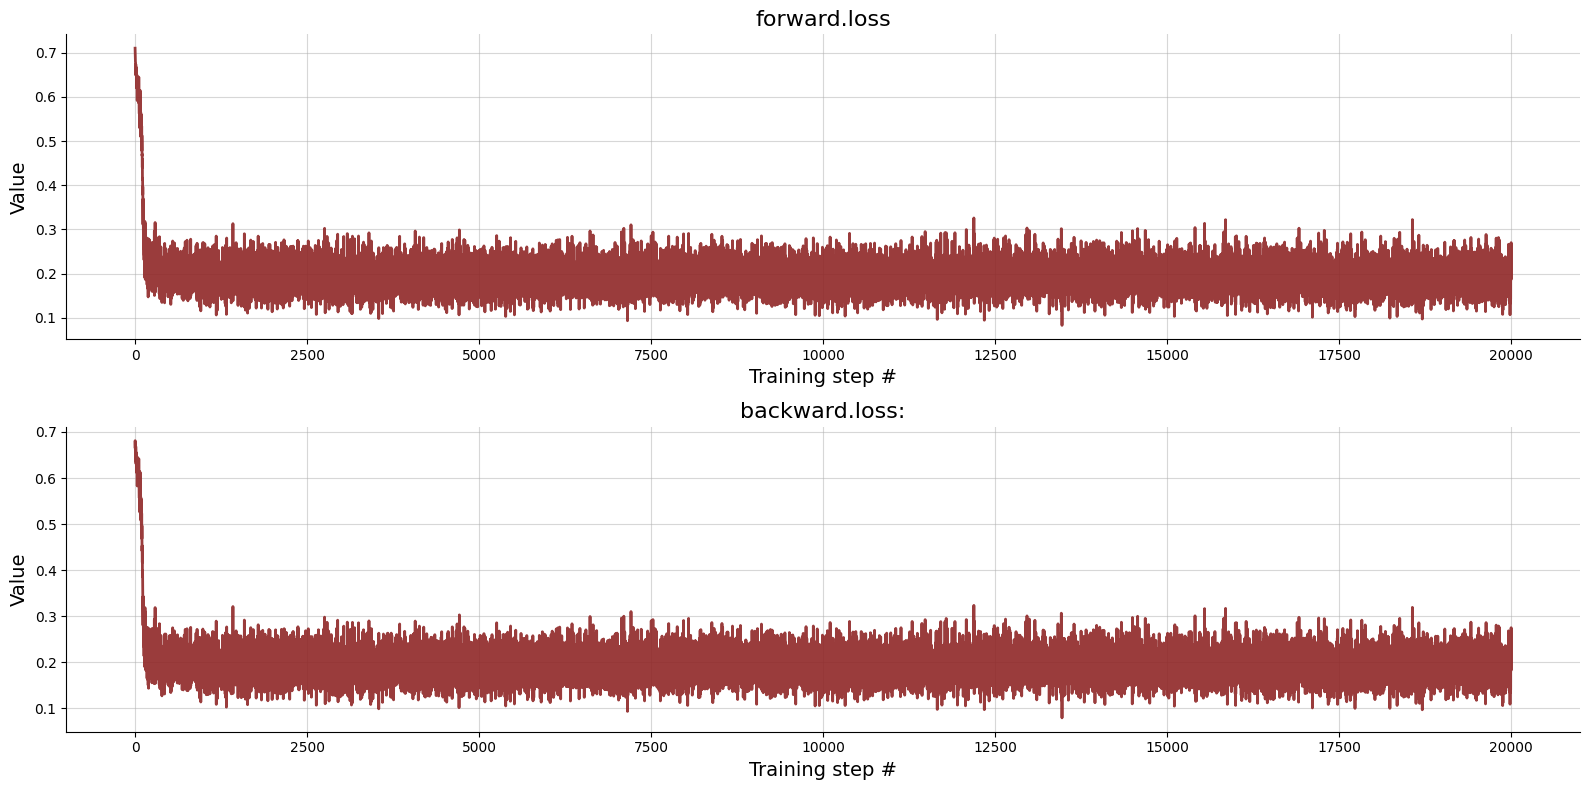

In [9]:
if train:
    f = bf.diagnostics.plot_losses(h)